In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("dataAnnotated.csv", encoding="utf-8")

In [3]:
data = data.fillna(method="ffill")

In [7]:
data.head(60)

,Line#,Word,Tag
0,Line0,De,NoTag
1,Line0,tous,NoTag
2,Line0,les,NoTag
3,Line0,poëtes,NoTag
4,Line0,de‧l',NoTag
5,Line0,"Antiquité,",NoTag
6,Line0,Pindare,OEUVRES
7,Line1,est,NoTag
8,Line1,certainement,NoTag
9,Line1,aujourd',NoTag


In [138]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

35708

In [139]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

7

In [140]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Line#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Line{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [141]:
getter = SentenceGetter(data)
sen = getter.get_next()
print(sen)

[('est', 'NoTag'), ('certainement', 'NoTag'), ("aujourd'", 'NoTag'), ('hui', 'NoTag'), ('le', 'NoTag'), ('plus', 'NoTag'), ('éloigné', 'NoTag'), ('de', 'NoTag'), ('nous.', 'NoTag'), ('Plus', 'NoTag'), ("qu'", 'NoTag'), ('aucun', 'NoTag'), ('des', 'NoTag'), ('grands', 'NoTag'), ('écrivains,', 'NoTag'), ('il', 'NoTag'), ('appartient', 'NoTag'), ('à', 'NoTag'), ('son', 'NoTag'), ('temps', 'NoTag'), ('et', 'NoTag'), ('ne', 'NoTag'), ('le', 'NoTag'), ('dépasse', 'NoTag'), ('guère.', 'NoTag'), ('Il', 'NoTag'), ('incarne', 'NoTag'), ('les', 'NoTag'), ('idées,', 'NoTag'), ('les', 'NoTag'), ('sentiments', 'NoTag'), ('de', 'NoTag'), ('son', 'NoTag'), ('époque', 'NoTag'), ('sans', 'NoTag'), ('jamais', 'NoTag'), ('les', 'NoTag'), ('dominer', 'NoTag'), ('-', 'NoTag'), ('autrement', 'NoTag'), ('que', 'NoTag'), ('par', 'NoTag'), ('la', 'NoTag'), ('beauté', 'NoTag'), ('de', 'NoTag'), ('son', 'NoTag'), ('style.', 'NoTag'), ('Que', 'NoTag'), ('dis-je?', 'NoTag'), ('Ce', 'NoTag'), ('ne', 'NoTag'), ('sont

In [142]:
getter = SentenceGetter(data)
sentences = getter.sentences
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [143]:
print(tag2idx["PERSONNAGES"])

3


Now we map the sentences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero.
And we need to do the same for our tag sequence.
For training the network we also need to change the labels yy to categorial.

In [144]:
max_len = 75
max_len_char = 20

In [145]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

125


In [146]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


We split in train and test set.

In [147]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [148]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


In [149]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)


In [150]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 75, 20)]     0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 75, 20, 10)   1270        input_12[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 75, 20)       714200      input_11[0][0]                   
____________________________________________________________________________________________

In [151]:
history2 = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


Epoch 1/10
255/255 [==============================] - 80s 277ms/step - loss: 0.2649 - acc: 0.9423 - val_loss: 0.0396 - val_acc: 0.9668
Epoch 2/10
255/255 [==============================] - 72s 281ms/step - loss: 0.0386 - acc: 0.9661 - val_loss: 0.0323 - val_acc: 0.9668
Epoch 3/10
255/255 [==============================] - 71s 280ms/step - loss: 0.0316 - acc: 0.9669 - val_loss: 0.0229 - val_acc: 0.9796
Epoch 4/10
255/255 [==============================] - 73s 286ms/step - loss: 0.0197 - acc: 0.9834 - val_loss: 0.0121 - val_acc: 0.9904
Epoch 5/10
255/255 [==============================] - 72s 282ms/step - loss: 0.0111 - acc: 0.9917 - val_loss: 0.0093 - val_acc: 0.9914
Epoch 6/10
255/255 [==============================] - 73s 288ms/step - loss: 0.0075 - acc: 0.9942 - val_loss: 0.0075 - val_acc: 0.9926
Epoch 7/10
255/255 [==============================] - 73s 287ms/step - loss: 0.0056 - acc: 0.9956 - val_loss: 0.0060 - val_acc: 0.9943
Epoch 8/10
255/255 [==============================] - 7

INFO:tensorflow:Assets written to: my_model\assets


In [152]:
hist2 = pd.DataFrame(history2.history)

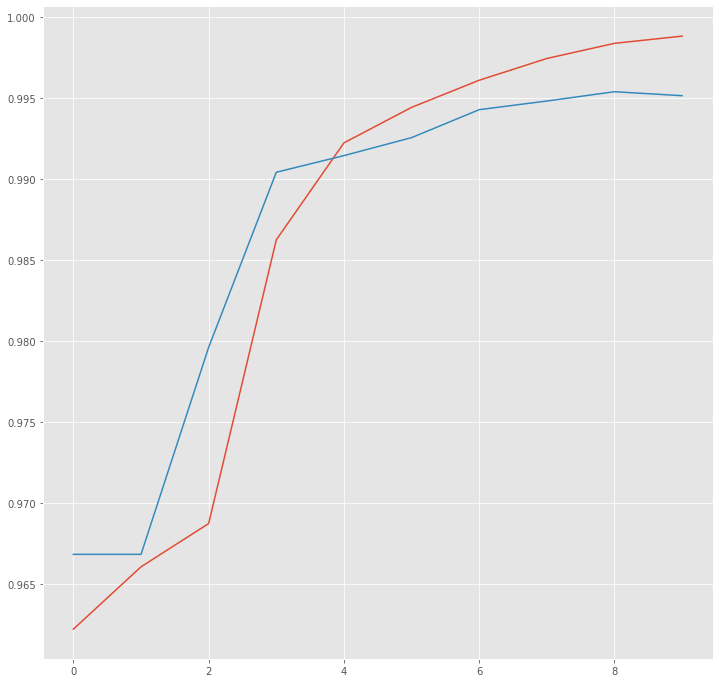

In [153]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist2["acc"])
plt.plot(hist2["val_acc"])
plt.show()

In [154]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [160]:
for i in range(1000) : 
    p = np.argmax(y_pred[i], axis=-1)
    print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    print(30 * "=")
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
sont           : NoTag NoTag
particulièrement: NoTag NoTag
denses         : NoTag NoTag
et             : NoTag NoTag
bien           : NoTag NoTag
écrites.       : NoTag NoTag
Elles          : NoTag NoTag
offrent        : NoTag NoTag
de             : NoTag NoTag
plus           : NoTag NoTag
l'             : NoTag NoTag
avantage       : NoTag NoTag
d'             : NoTag NoTag
avoir          : NoTag NoTag
une            : NoTag NoTag
signification  : NoTag NoTag
générale.      : NoTag NoTag
Je             : NoTag NoTag
veux           : NoTag NoTag
dire           : NoTag NoTag
par            : NoTag NoTag
là             : NoTag NoTag
qu'            : NoTag NoTag
elles          : NoTag NoTag
offrent        : NoTag NoTag
des            : NoTag NoTag
images         : NoTag NoTag
de‧la          : NoTag NoTag
vie            : NoTag NoTag
qui            : NoTag NoTag
ont            : NoTag NoTag
un             : NoTag NoTag
sens           : NoTag NoTag
et           

I :            : NoTag NoTag
Souvenirs      : OEUVRES OEUVRES
Word           ||True ||Pred
puisque,       : NoTag NoTag
lorsque        : NoTag NoTag
je             : NoTag NoTag
partis         : NoTag NoTag
pour           : NoTag NoTag
les            : NoTag NoTag
États-Unis,    : NoTag NoTag
au             : NoTag NoTag
début          : NoTag NoTag
de‧la          : NoTag NoTag
guerre,        : NoTag NoTag
je             : NoTag NoTag
laissai        : NoTag NoTag
le             : NoTag NoTag
manuscrit      : NoTag NoTag
et             : NoTag NoTag
la             : NoTag NoTag
plus           : NoTag NoTag
grande         : NoTag NoTag
partie         : NoTag NoTag
de             : NoTag NoTag
mes            : NoTag NoTag
notes          : NoTag NoTag
en             : NoTag NoTag
Europe         : LIEUX LIEUX
.              : NoTag NoTag
Word           ||True ||Pred
n              : NoTag NoTag
du             : NoTag NoTag
vid            : NoTag NoTag
Mishima        : AUTHORS AUTHORS
Word  

jours          : NoTag NoTag
après          : NoTag NoTag
sa             : NoTag NoTag
naissance.     : NoTag NoTag
Word           ||True ||Pred
et             : NoTag NoTag
Yseut          : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
,              : NoTag NoTag
passant        : NoTag NoTag
du             : NoTag NoTag
palace         : NoTag NoTag
au             : NoTag NoTag
garni,         : NoTag NoTag
mais           : NoTag NoTag
aussi          : NoTag NoTag
du             : NoTag NoTag
garni          : NoTag NoTag
au             : NoTag NoTag
palace.        : NoTag NoTag
« L'           : NoTag NoTag
avenir         : NoTag NoTag
lui            : NoTag NoTag
réserve        : NoTag NoTag
son            : NoTag NoTag
plus           : NoTag NoTag
grand          : NoTag NoTag
amour,         : NoTag NoTag
pour           : NoTag NoTag
une            : NoTag NoTag
femme          : NoTag NoTag
très           : NoTag NoTag
digne          : NoTag NoTag
de             : NoTag NoTag
te

Word           ||True ||Pred
certaines      : NoTag NoTag
sélections     : NoTag NoTag
(qu'           : NoTag NoTag
apporte,       : NoTag NoTag
aussi          : NoTag NoTag
isolé,         : NoTag NoTag
le             : NoTag NoTag
billet         : NoTag NoTag
à              : NoTag NoTag
Pierre de Boisdeffre: CRITIQUES CRITIQUES
 ?).           : NoTag NoTag
Mais           : NoTag NoTag
tout           : NoTag NoTag
travail        : NoTag NoTag
pionnier       : NoTag NoTag
encourt        : NoTag NoTag
ce             : NoTag NoTag
genre          : NoTag NoTag
de             : NoTag NoTag
reproches.     : NoTag NoTag
Ne             : NoTag NoTag
boudons        : NoTag NoTag
pas,           : NoTag NoTag
donc,          : NoTag NoTag
le             : NoTag NoTag
plaisir        : NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
nous           : NoTag NoTag
propose        : NoTag NoTag
pour           : NoTag NoTag
préciser       : NoTag NoTag
le             : NoTag NoTag
p

titre          : NoTag NoTag
de             : NoTag NoTag
Fleuve         : NoTag NoTag
profond,       : NoTag NoTag
sombre         : NoTag NoTag
rivière,       : NoTag NoTag
une            : NoTag NoTag
anthologie     : NoTag NoTag
de             : NoTag NoTag
negro-spirituals,: NoTag NoTag
consacrant     : NoTag NoTag
un             : NoTag NoTag
important      : NoTag NoTag
essai          : NoTag NoTag
à              : NoTag NoTag
Pindare.       : NoTag NoTag
Particulièrement: NoTag NoTag
attirée        : NoTag NoTag
jusqu'         : NoTag NoTag
ici            : NoTag NoTag
par            : NoTag NoTag
la             : NoTag NoTag
Grèce          : NoTag LIEUX
et             : NoTag NoTag
par            : NoTag NoTag
l'             : NoTag NoTag
Word           ||True ||Pred
me             : NoTag NoTag
s'             : NoTag NoTag
il             : NoTag NoTag
n'             : NoTag NoTag
évoque         : NoTag NoTag
l'             : NoTag NoTag
auteur         : NoTag NoTag
de‧la      

figuré         : NoTag NoTag
par            : NoTag NoTag
un             : NoTag NoTag
lit            : NoTag NoTag
solennel,      : NoTag NoTag
orné           : NoTag NoTag
d'             : NoTag NoTag
un             : NoTag NoTag
ciel           : NoTag NoTag
de             : NoTag NoTag
lit,           : NoTag NoTag
et             : NoTag NoTag
dont           : NoTag NoTag
les            : NoTag NoTag
draps          : NoTag NoTag
très           : NoTag NoTag
blancs         : NoTag NoTag
de             : NoTag NoTag
fine           : NoTag NoTag
toile          : NoTag NoTag
essuieront     : NoTag NoTag
le             : NoTag NoTag
sang,          : NoTag NoTag
les            : NoTag NoTag
ordures        : NoTag NoTag
et             : NoTag NoTag
les            : NoTag NoTag
sueurs         : NoTag NoTag
de‧l'          : NoTag NoTag
accouchement.  : NoTag NoTag
Les            : NoTag NoTag
grandes        : NoTag NoTag
chambres       : NoTag NoTag
1900           : NoTag NoTag
aux           

empruntés      : NoTag NoTag
à              : NoTag NoTag
la             : NoTag NoTag
biographie     : NoTag NoTag
des            : NoTag NoTag
savants        : NoTag NoTag
et             : NoTag NoTag
des            : NoTag NoTag
chercheurs     : NoTag NoTag
les            : NoTag NoTag
plus           : NoTag NoTag
illustres      : NoTag NoTag
de             : NoTag NoTag
cette          : NoTag NoTag
époque         : NoTag NoTag
extraordinaire,: NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
s'             : NoTag NoTag
agisse         : NoTag NoTag
d'             : NoTag NoTag
Ambroise Paré  : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
Vers           : NoTag NoTag
l'             : NoTag NoTag
âge            : NoTag NoTag
de             : NoTag NoTag
quinze         : NoTag NoTag
ans,           : NoTag NoTag
Nathanaël      : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
bout           : NoTag NoTag
de‧la          : NoTag NoTag
nuit -         : No

chez           : NoTag NoTag
le             : NoTag NoTag
barbare        : NoTag NoTag
et             : NoTag NoTag
il             : NoTag NoTag
s'             : NoTag NoTag
est            : NoTag NoTag
en             : NoTag NoTag
partie         : NoTag NoTag
dégoûté        : NoTag NoTag
de‧la          : NoTag NoTag
médecine,      : NoTag NoTag
il             : NoTag NoTag
est            : NoTag NoTag
ingénieur      : NoTag NoTag
à              : NoTag NoTag
sa             : NoTag NoTag
manière,       : NoTag NoTag
il             : NoTag NoTag
pressent       : NoTag NoTag
les            : NoTag NoTag
puissances     : NoTag NoTag
de‧la          : NoTag NoTag
technique      : NoTag NoTag
et             : NoTag NoTag
il             : NoTag NoTag
a              : NoTag NoTag
éprouvé        : NoTag NoTag
le             : NoTag NoTag
poids          : NoTag NoTag
et             : NoTag NoTag
la             : NoTag NoTag
sottise        : NoTag NoTag
souvent        : NoTag NoTag
sanglante     

médiocres      : NoTag NoTag
nous           : NoTag NoTag
racontaient    : NoTag NoTag
l'             : NoTag NoTag
histoire       : NoTag NoTag
de             : NoTag NoTag
Napoléon       : NoTag NoTag
ou             : NoTag NoTag
Word           ||True ||Pred
Herald,        : NoTag NoTag
puis           : NoTag NoTag
comme          : NoTag NoTag
professeur.    : NoTag NoTag
Elle           : NoTag NoTag
a              : NoTag NoTag
épousé         : NoTag NoTag
un             : NoTag NoTag
caricaturiste  : NoTag NoTag
du             : NoTag NoTag
journal        : NoTag NoTag
et             : NoTag NoTag
a              : NoTag NoTag
vécu           : NoTag NoTag
avec           : NoTag NoTag
lui            : NoTag NoTag
jusqu'         : NoTag NoTag
à              : NoTag NoTag
sa             : NoTag NoTag
mort           : NoTag NoTag
à              : NoTag NoTag
lui,           : NoTag NoTag
en             : NoTag NoTag
1961.          : NoTag NoTag
Ils            : NoTag NoTag
vivaient      

Mais           : NoTag NoTag
c'             : NoTag NoTag
est            : NoTag NoTag
à              : NoTag NoTag
la             : NoTag NoTag
réflexion      : NoTag NoTag
personnelle    : NoTag NoTag
la             : NoTag NoTag
plus           : NoTag NoTag
patiente       : NoTag NoTag
d'             : NoTag NoTag
opérer         : NoTag NoTag
le             : NoTag NoTag
choix          : NoTag NoTag
définitif,     : NoTag NoTag
celui          : NoTag NoTag
de‧la          : NoTag NoTag
Word           ||True ||Pred
(5)            : NoTag NoTag
Les            : NoTag NoTag
œuvres         : NoTag NoTag
de             : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
— C'           : NoTag NoTag
est            : NoTag NoTag
une            : NoTag NoTag
question       : NoTag NoTag
d'             : NoTag NoTag
oreille        : NoTag NoTag
de             : NoTag NoTag
réussir        : NoTag NoTag
à              : NoTag NoTag
retrouver      : NoTag NoTag
le   

trois          : NoTag NoTag
siècles        : NoTag NoTag
d'             : NoTag NoTag
histoire       : NoTag NoTag
dans           : NoTag NoTag
la             : NoTag NoTag
vie            : NoTag NoTag
d'             : NoTag NoTag
une            : NoTag NoTag
château,       : NoTag NoTag
on             : NoTag NoTag
rencontre      : NoTag NoTag
Piranèse       : NoTag NoTag
dans           : NoTag NoTag
l'             : NoTag NoTag
univers        : NoTag NoTag
gravé          : NoTag NoTag
de             : NoTag NoTag
ses            : NoTag NoTag
Antiquités     : NoTag NoTag
de             : NoTag NoTag
Rome           : NoTag NoTag
et             : NoTag NoTag
dans           : NoTag NoTag
la             : NoTag NoTag
vision         : NoTag NoTag
hallucinée     : NoTag NoTag
de             : NoTag NoTag
ses            : NoTag NoTag
Prisons        : NoTag OEUVRES
imaginaires,   : NoTag NoTag
on             : NoTag NoTag
Word           ||True ||Pred
Rappelons      : NoTag NoTag
aussi       

un             : NoTag NoTag
premier        : NoTag NoTag
capitalisme    : NoTag NoTag
international  : NoTag NoTag
vite           : NoTag NoTag
plus           : NoTag NoTag
effectivement  : NoTag NoTag
puissant       : NoTag NoTag
que            : NoTag NoTag
les            : NoTag NoTag
princes        : NoTag NoTag
et             : NoTag NoTag
les            : NoTag NoTag
empereurs,     : NoTag NoTag
et             : NoTag NoTag
finalement     : NoTag NoTag
faisant        : NoTag NoTag
craquer        : NoTag NoTag
de             : NoTag NoTag
partout        : NoTag NoTag
la             : NoTag NoTag
tunique        : NoTag NoTag
sans           : NoTag NoTag
couture.       : NoTag NoTag
Word           ||True ||Pred
s              : NoTag NoTag
ou             : NoTag NoTag
le             : NoTag NoTag
traité         : NoTag NoTag
du             : NoTag NoTag
vain           : NoTag NoTag
combat         : NoTag NoTag
Mémoires d' Hadrien: OEUVRES OEUVRES
Word           ||True ||Pred
demeur

jeune          : NoTag NoTag
homme          : NoTag NoTag
— qui          : NoTag NoTag
se             : NoTag NoTag
fera           : NoTag NoTag
tatouer        : NoTag NoTag
sur            : NoTag NoTag
l'             : NoTag NoTag
avant-bras     : NoTag NoTag
le             : NoTag NoTag
mot            : NoTag NoTag
mystérieux     : NoTag NoTag
d'             : NoTag NoTag
Ananké —       : NoTag NoTag
ne             : NoTag NoTag
cessera        : NoTag NoTag
plus           : NoTag NoTag
de             : NoTag NoTag
le             : NoTag NoTag
provoquer.     : NoTag NoTag
Que            : NoTag NoTag
de             : NoTag NoTag
contrastes !   : NoTag NoTag
Pour           : NoTag NoTag
braver         : NoTag NoTag
sa             : NoTag NoTag
famille,       : NoTag NoTag
ce             : NoTag NoTag
fils           : NoTag NoTag
d'             : NoTag NoTag
un             : NoTag NoTag
« homme        : NoTag NoTag
d'             : NoTag NoTag
ordre »        : NoTag NoTag
compose       

avoir          : NoTag NoTag
dirigé         : NoTag NoTag
les            : NoTag NoTag
programmes     : NoTag NoTag
de             : NoTag NoTag
RTL            : NoTag NoTag
pendant        : NoTag NoTag
près           : NoTag NoTag
de             : NoTag NoTag
trente         : NoTag NoTag
ans,           : NoTag NoTag
travailla      : NoTag NoTag
avec           : NoTag NoTag
acharnement    : NoTag NoTag
au             : NoTag NoTag
sein           : NoTag NoTag
du             : NoTag NoTag
Secours        : NoTag NoTag
catholique     : NoTag NoTag
français,      : NoTag NoTag
et             : NoTag NoTag
se             : NoTag NoTag
donna,         : NoTag NoTag
corps          : NoTag NoTag
et             : NoTag NoTag
plume,         : NoTag NoTag
à              : NoTag NoTag
l'             : NoTag NoTag
application    : NoTag NoTag
des            : NoTag NoTag
principes      : NoTag NoTag
évangéliques   : NoTag NoTag
dans           : NoTag NoTag
un             : NoTag NoTag
monde         

Cette          : NoTag NoTag
histoire       : NoTag NoTag
tragique       : NoTag NoTag
et             : NoTag NoTag
cruelle,       : NoTag NoTag
le             : NoTag NoTag
XIXe           : NoTag NoTag
siècle         : NoTag NoTag
l'             : NoTag NoTag
avait          : NoTag NoTag
reléguée       : NoTag NoTag
dans           : NoTag NoTag
un             : NoTag NoTag
inaccessible   : NoTag NoTag
passé ;        : NoTag NoTag
c'             : NoTag NoTag
est            : NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
la             : NoTag NoTag
jugeait        : NoTag NoTag
du             : NoTag NoTag
haut           : NoTag NoTag
d'             : NoTag NoTag
une            : NoTag NoTag
morale         : NoTag NoTag
puritaine.     : NoTag NoTag
Mais           : NoTag NoTag
le             : NoTag NoTag
lecteur        : NoTag NoTag
moderne        : NoTag NoTag
a              : NoTag NoTag
appris,        : NoTag NoTag
hélas !        : NoTag NoTag
à             

compagne,      : NoTag NoTag
à              : NoTag NoTag
avoir          : NoTag NoTag
décidé         : NoTag NoTag
trop           : NoTag NoTag
tôt            : NoTag NoTag
sa             : NoTag NoTag
retraite       : NoTag NoTag
au             : NoTag NoTag
sens           : NoTag NoTag
noble          : NoTag NoTag
du             : NoTag NoTag
mot            : NoTag NoTag
et             : NoTag NoTag
avoir          : NoTag NoTag
de‧la          : NoTag NoTag
même           : NoTag NoTag
façon          : NoTag NoTag
consenti       : NoTag NoTag
trop           : NoTag NoTag
vite           : NoTag NoTag
à              : NoTag NoTag
vieillir,      : NoTag NoTag
la             : NoTag NoTag
vie            : NoTag NoTag
qu'            : NoTag NoTag
elle           : NoTag NoTag
aimait         : NoTag NoTag
avec           : NoTag NoTag
« avidité »    : NoTag NoTag
se             : NoTag NoTag
vengeait.      : NoTag NoTag
Au             : NoTag NoTag
moment         : NoTag NoTag
où            

même           : NoTag NoTag
guerre         : NoTag NoTag
força          : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
(et            : NoTag NoTag
ses            : NoTag NoTag
sept           : NoTag NoTag
frères         : NoTag NoTag
et             : NoTag NoTag
sœurs).        : NoTag NoTag
Justement,     : NoTag NoTag
comment        : NoTag NoTag
fut            : NoTag NoTag
élevée         : NoTag NoTag
Fernande       : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
Il             : NoTag NoTag
n'             : NoTag NoTag
y              : NoTag NoTag
a              : NoTag NoTag
pas            : NoTag NoTag
un             : NoTag NoTag
Québécois,     : NoTag NoTag
né             : NoTag NoTag
aux            : NoTag NoTag
abords         : NoTag NoTag
de‧la          : NoTag NoTag
Seconde        : NoTag NoTag
Guerre         : NoTag NoTag
mondiale       : NoTag NoTag
ou             : NoTag NoTag
plus           : NoTag NoTag
tôt,           : NoTag

pourquoi)      : NoTag NoTag
est            : NoTag NoTag
une            : NoTag NoTag
comète         : NoTag NoTag
de‧la          : NoTag NoTag
vie            : NoTag NoTag
littéraire ;   : NoTag NoTag
elle           : NoTag NoTag
fut            : NoTag NoTag
signalée       : NoTag NoTag
deux           : NoTag NoTag
fois           : NoTag NoTag
dans           : NoTag NoTag
ce             : NoTag NoTag
si,ècle        : NoTag NoTag
(curieusement, : NoTag NoTag
on             : NoTag NoTag
ne             : NoTag NoTag
trouve         : NoTag NoTag
pas            : NoTag NoTag
trace          : NoTag NoTag
de             : NoTag NoTag
Madame Y       : AUTHORS AUTHORS
Word           ||True ||Pred
ouvre          : NoTag NoTag
sa             : NoTag NoTag
« fantaisie    : NoTag NoTag
inspirée       : NoTag NoTag
par            : NoTag NoTag
les            : NoTag NoTag
lacunes        : NoTag NoTag
de‧l'          : NoTag NoTag
Histoire »     : NoTag NoTag
sur            : NoTag NoTag
une       

In [161]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets
